Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [6]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import accumulate
from tqdm.auto import tqdm

from icecream import ic

logging.basicConfig(level=logging.DEBUG)

In [7]:
CITIES = pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2): #Prende l'array ci cities e fa gruppi di 2 
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()

,name,lat,lon
0,Abakan,53.72,91.43
1,Achinsk,56.28,90.50
2,Almetyevsk,54.90,52.31
3,Angarsk,52.57,103.91
4,Arkhangelsk,64.57,40.53


## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [8]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## First Greedy Algorithm

100%|██████████| 167/167 [00:00<00:00, 1588.84it/s]


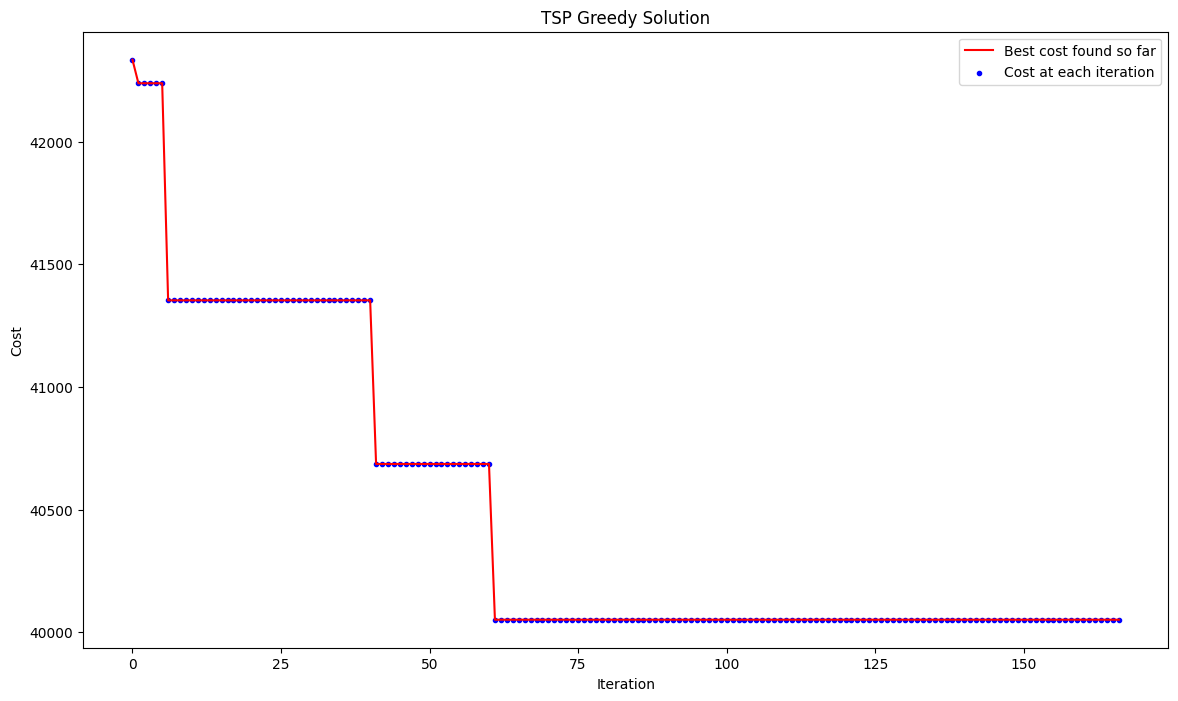

ic| best_path: np.float64(40051.58704748039)


np.float64(40051.58704748039)

In [9]:
best_path = np.inf
best_cities = list()
cost_history = []
for ci in tqdm(range(len(CITIES))):
    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    city = ci
    visited[city] = True
    tsp = list()
    tsp.append(int(city))
    list_cities = list()
    list_cities.append(int(ci))
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        visited[closest] = True
        city = closest
        tsp.append(int(city))
        list_cities.append(int(city))
    tsp.append(tsp[0])

    cost_history.append(min(tsp_cost(tsp), best_path))

    if tsp_cost(tsp) < best_path:
        best_path = tsp_cost(tsp)
        best_cities = list_cities
    

#ic(best_path)
#ic(list_cities)

# Grafico dell'andamento dei costi
plt.figure(figsize=(14, 8))
plt.plot(range(len(cost_history)), list(accumulate(cost_history, min)), color="red", label='Best cost found so far')
plt.scatter(range(len(cost_history)), cost_history, marker=".", color="blue", label='Cost at each iteration')
plt.title("TSP Greedy Solution")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.show()

ic(best_path)


## Evolutionary Algorithm

100%|██████████| 10000/10000 [02:16<00:00, 73.11it/s]


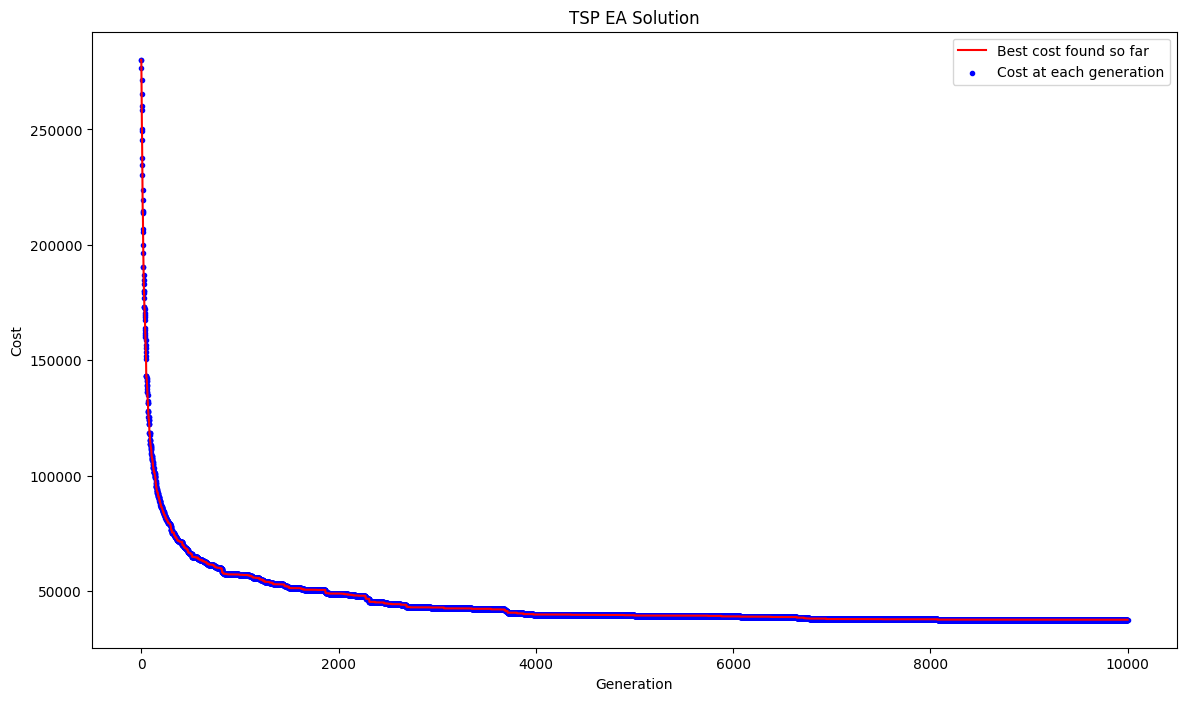

ic| 'Best path: ', bc: np.float64(37515.41131279262)


('Best path: ', np.float64(37515.41131279262))

In [10]:
def evolutionary_algorithm(cities, population_size=100, generations=10_000, mutation_rate=0.02, elite_size=5):
    #creo la popolazione con population_size percorsi casuali. 
    # Ogni percorso è una permutazione casuale delle città da visitare
    #random.sample(range(len(cities)), len(cities)) -> genero un intervallo che va da 0 a len(cities)-1 e ne prendo len(cities) ordinate in modo randomico
    population = [random.sample(range(len(cities)), len(cities)) for _ in range(population_size)]
    cost_history = []

    def evaluate_population(pop):
        #calcolo il costo di ogni percorso aggiungendo il ritorno alla città di partenza
        #con [individual[0]] è come se alla fine della lista aggiungessi un nuovo elemento
        return [tsp_cost(individual + [individual[0]]) for individual in pop]

    def tournament_selection(pop, fitness_scores, k=5):
        #scelgo k invididui casuali dalla popolazione e li ordino in base al costo e restituisco il migliore
        #seleziono i migliori percorsi (con costo minore) per la riproduzione, mantenendo una componente casuale
        #list(zip(pop, fitness_scores)) -> con zip genero tuple in cui il primo elemento è un percorso della popolazione
        #e il secondo è il costo corrispondente
        #con list converto tutto in una lista
        selected = random.sample(list(zip(pop, fitness_scores)), k)
        selected.sort(key=lambda x: x[1])
        return selected[0][0]

    def ordered_crossover(parent1, parent2):
        #mescolo i geni dei genitori per generare un nuovo percorso
        #una parte del percorso la copio direttamente dal parent1, mentre le città rimanenti le prendo
        #dal parent2 nell'ordine originale, evitando duplicati
        start, end = sorted(random.sample(range(len(parent1)), 2))
        #inizializzo una lista di lunghezza len(parent1) ma riempita con -1
        child = [-1] * len(parent1)
        child[start:end] = parent1[start:end]
        idx = end
        for city in parent2:
            if city not in child:
                if idx >= len(parent1):
                    idx = 0
                child[idx] = city
                idx += 1
        return child

    def mutate(individual):
        #scambio l'ordine di una sottosequenza casuale nel percorso con una certa probabilità
        if random.random() < mutation_rate:
            idx1, idx2 = sorted(random.sample(range(len(individual)), 2))
            #inverto l'ordine degli elementi selezionati
            individual[idx1:idx2] = individual[idx1:idx2][::-1]

    for generation in tqdm(range(generations)):
        #calcolo il coato di tutti i percorsi
        fitness_scores = evaluate_population(population)
        #ordino la popolazione e mantengo solo gli elite_size migliori percorsi
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population))]
        new_population = sorted_population[:elite_size]

        # Registro il miglior costo di questa generazione
        cost_history.append(min(fitness_scores))

        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitness_scores)
            parent2 = tournament_selection(population, fitness_scores)
            child = ordered_crossover(parent1, parent2)
            mutate(child)
            new_population.append(child)

        population = new_population

    best_individual = min(population, key=lambda x: tsp_cost(x + [x[0]]))
    best_cost = tsp_cost(best_individual + [best_individual[0]])
    
    # Grafico dell'andamento dei costi
    plt.figure(figsize=(14, 8))
    plt.plot(range(len(cost_history)), list(accumulate(cost_history, min)), color="red", label='Best cost found so far')
    plt.scatter(range(len(cost_history)), cost_history, marker=".", color="blue", label='Cost at each generation')
    plt.title("TSP EA Solution")
    plt.xlabel("Generation")
    plt.ylabel("Cost")
    plt.legend()
    plt.show()

    return best_individual + [best_individual[0]], best_cost

# Esempio di utilizzo con i dati del TSP
bi, bc = evolutionary_algorithm(CITIES)
ic("Best path: ", bc)
